<QuarterBegin: startingMonth=10>


<IPython.core.display.Javascript object>


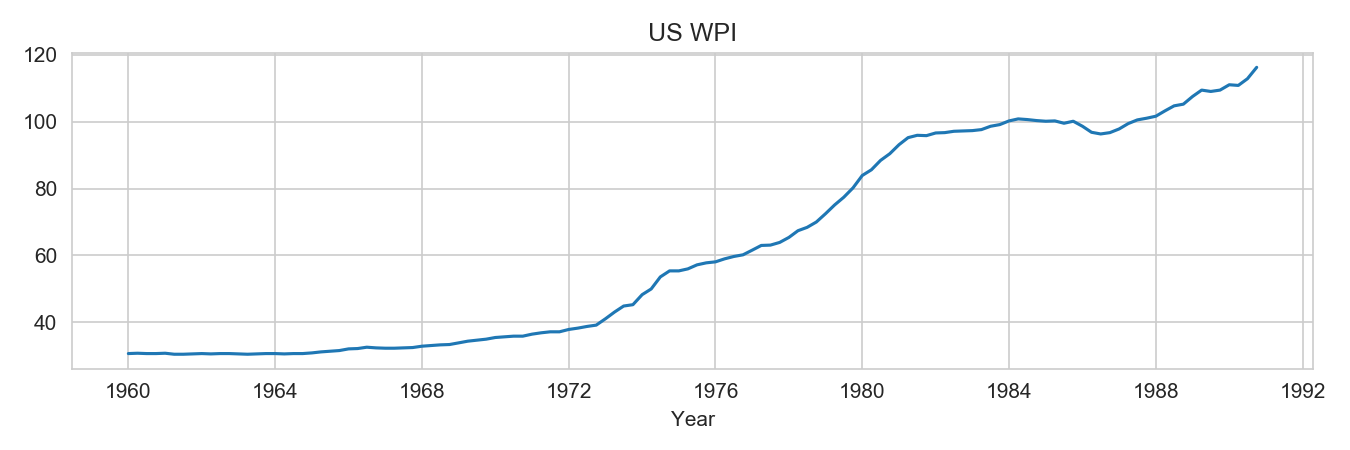

,wpi,ln_wpi,diff_ln_wpi
t,,,
1960-01-01,30.700001,3.424263,NaN
1960-04-01,30.799999,3.427515,0.003252
1960-07-01,30.700001,3.424263,-0.003252
1960-10-01,30.700001,3.424263,0.000000
1961-01-01,30.799999,3.427515,0.003252


In [1]:
%matplotlib notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from numpy import exp

# Import data: U.S. Wholesale Price Index (WPI) using quarterly data over the period 1960q1 through 1990q4
# http://www.stata-press.com/data/r13/wpi1.dta
data = pd.read_stata('data/wpi1.dta',index_col='t')
# Set frequency of date index
data.index = pd.DatetimeIndex(data.index,freq='infer')
print(data.index.freq)

# Plot data: it's growing over time (not stationary) 
# assuming original time series be integrated of order 1, so the difference of order 1 assumed to be stationary
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(9,3))
sns.set_style("whitegrid")
sns.lineplot(data=data['wpi'])
plt.xlabel('Year')
plt.title('US WPI')
# Make the figure fit
plt.tight_layout()

# Create difference of logs
data['diff_ln_wpi'] = data['ln_wpi'].diff()
data.head()

In [51]:
# Fit a ARIMA model (1,1,1) by SARIMAX with constant trend
arima=(1,1,1)
model = SARIMAX(data['wpi'], trend='c', order=arima)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -135.351
Date:                Wed, 26 Jun 2019   AIC                            278.703
Time:                        20:48:09   BIC                            289.951
Sample:                    01-01-1960   HQIC                           283.272
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0943      0.068      1.389      0.165      -0.039       0.227
ar.L1          0.8742      0.055     16.028      0.000       0.767       0.981
ma.L1         -0.4120      0.100     -4.119      0.0

<IPython.core.display.Javascript object>


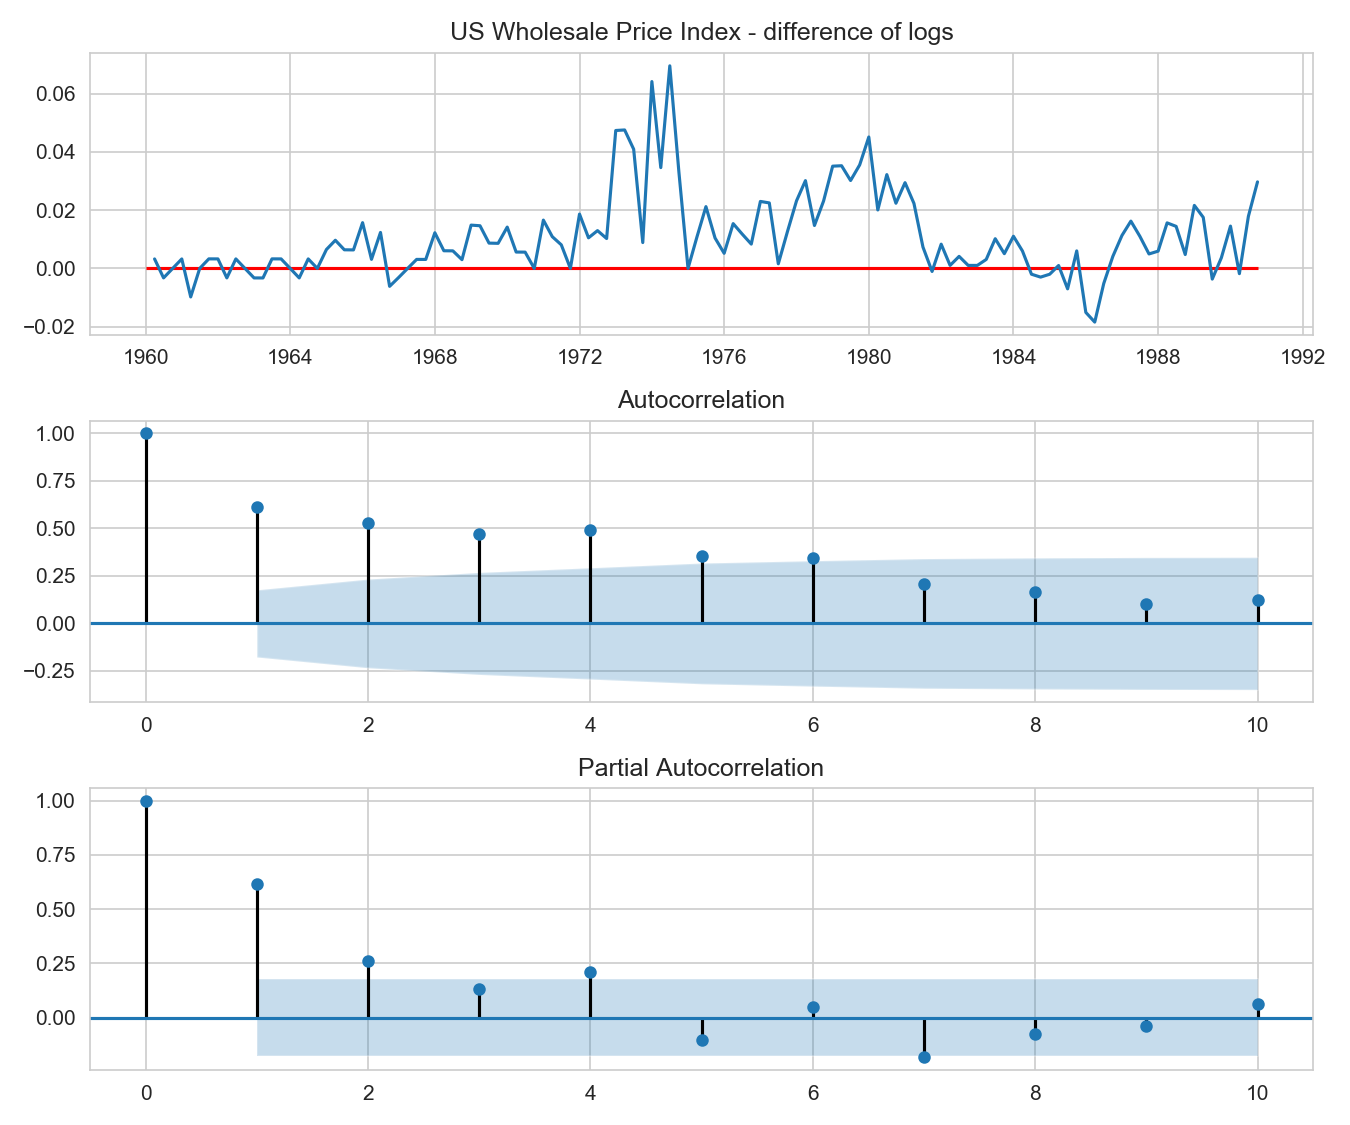

In [55]:
# Plot data
fig, axes = plt.subplots(3, 1, figsize=(9,7.5))
# Log difference
axes[0].plot(data.index._mpl_repr(), data['diff_ln_wpi'], '-')
axes[0].hlines(0, data.index[0], data.index[-1], 'r')
axes[0].set(title='US Wholesale Price Index - difference of logs');
# Compute and plot autocorrelation
# Skip first row with NAN value in difference
nLags=10
fig = sm.graphics.tsa.plot_acf(data[1:]['diff_ln_wpi'], lags=nLags, ax=axes[1])
plt.grid()

fig = sm.graphics.tsa.plot_pacf(data[1:]['diff_ln_wpi'], lags=nLags, ax=axes[2])
plt.grid()

# Make the figure fit
plt.tight_layout()

                             Statespace Model Results                            
Dep. Variable:                    ln_wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, (1, 4))   Log Likelihood                 386.034
Date:                   Wed, 26 Jun 2019   AIC                           -762.067
Time:                           22:21:23   BIC                           -748.006
Sample:                       01-01-1960   HQIC                          -756.356
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.484      0.138      -0.001       0.006
ar.L1          0.7807      0.094      8.264      0.000       0.596       0.966
ma.L1         -0.3993      0

<IPython.core.display.Javascript object>


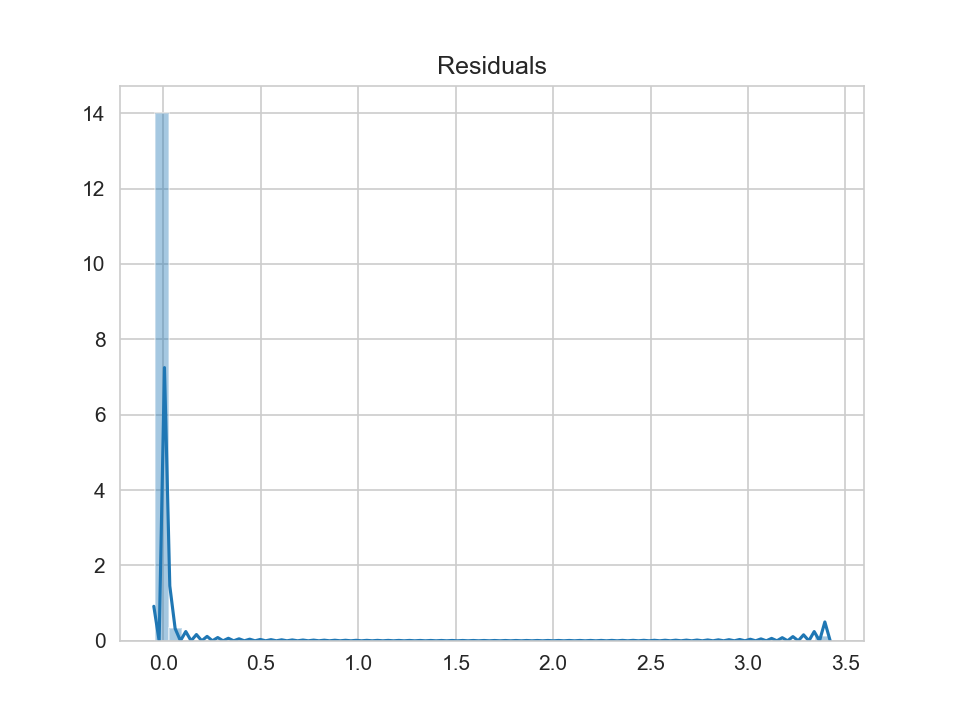

,0
count,124.000000
mean,0.027621
std,0.306688
min,-0.040766
25%,-0.005418
50%,0.000169
75%,0.004139
max,3.413247


In [7]:
# Analyze with SARIMAX model with additive seasonal effects
ar =1    
sma = (1,0,0,1)
model = SARIMAX(data['ln_wpi'], trend='c', order=(ar,1,sma))
model_fit = model.fit(disp=False)
print(model_fit.summary())

plt.figure()
sns.distplot(model_fit.resid)
plt.title('Residuals')
pd.DataFrame(model_fit.resid).describe()

In [8]:
# Validate model with 80-20 split
X = data['ln_wpi'].values
trainFraction=0.8
trainSize = int(len(X) * trainFraction)
train, test = X[0:trainSize], X[trainSize:len(X)]
predictions = []
for t in range(len(test)):
    model = SARIMAX(train, trend='c', order=(ar,1,sma))
    fitResults = model.fit(disp=0)
    output = fitResults.forecast(steps=t+1)
    # Forecast output is a 1D array with t+1 elements
    yhat = exp(output[t])
    predictions.append(yhat)
    obs = exp(test[t])
    if (t%10==0):
        print('%d: predicted=%f, expected=%f' % (t,yhat,obs))
error = mean_squared_error(exp(test), predictions)
print('Test MSE: %.3f' % error)

0: predicted=101.072300, expected=100.300003
10: predicted=108.831407, expected=99.399994
20: predicted=121.230650, expected=109.400024
Test MSE: 85.967


<IPython.core.display.Javascript object>


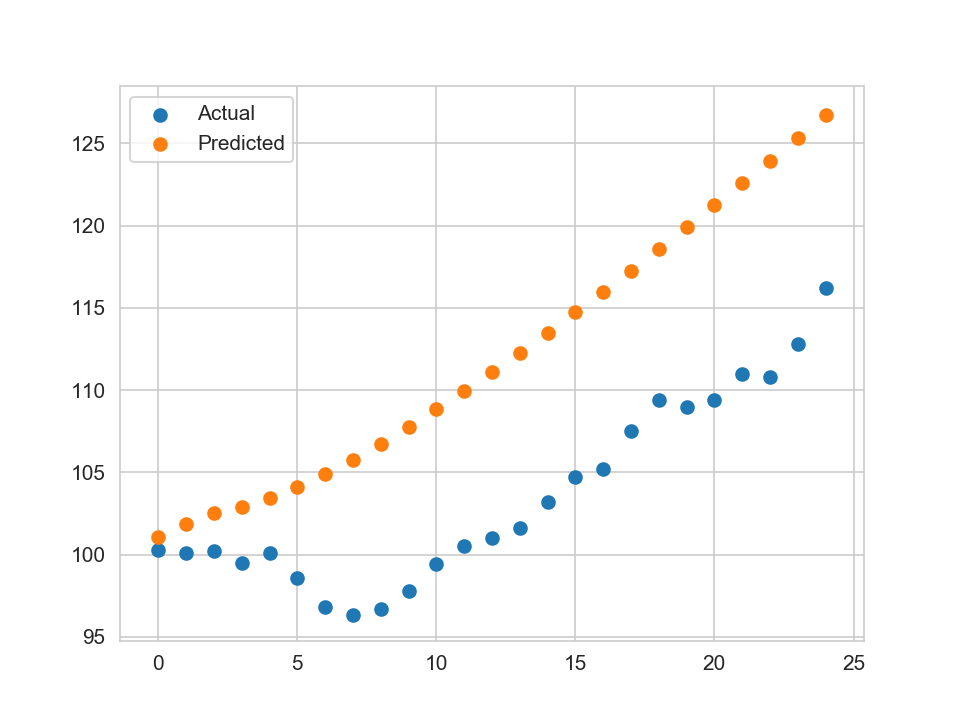

In [9]:
# Plot the predicted vs actual
plt.figure()
plt.scatter(y=exp(test),x=range(len(test)))
plt.scatter(y=predictions,x=range(len(test)))
plt.legend(['Actual','Predicted'])

<bound method DecomposeResult.plot of <statsmodels.tsa.seasonal.DecomposeResult object at 0x00000129C36C8898>>


<IPython.core.display.Javascript object>


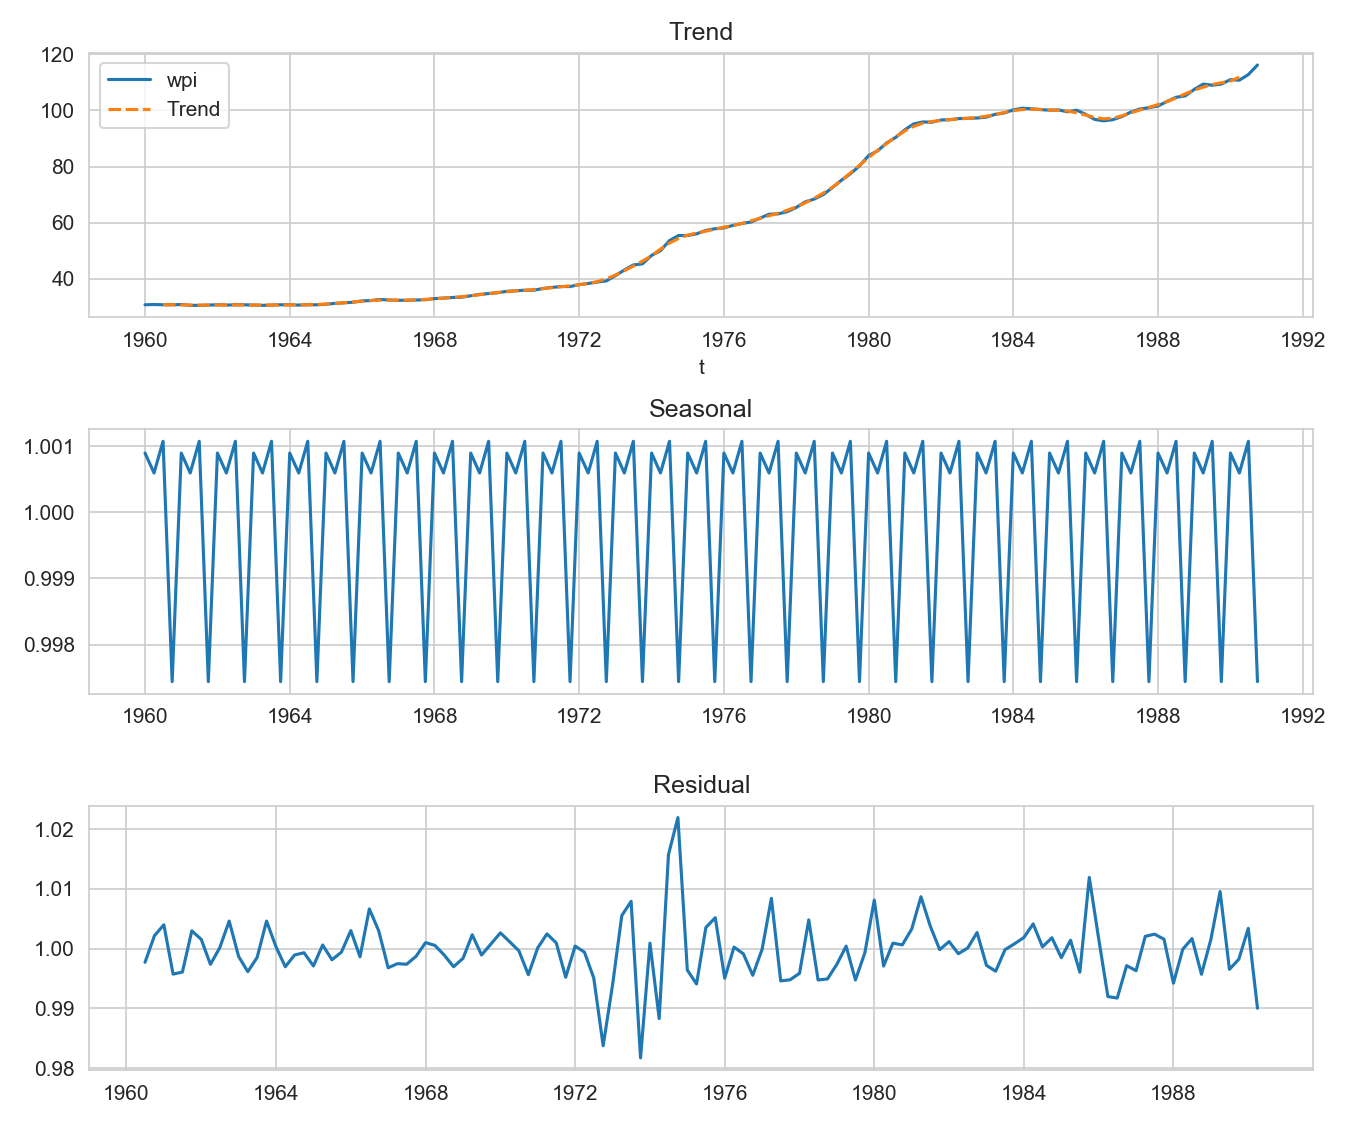

In [16]:
# Seasonal multiplicative decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['wpi'], model='multiplicative')
print(result.plot)

# Plot results
numRow=3
numCol=1

plt.figure(figsize=(numCol*9,numRow*2.5))
titles=['Trend','Seasonal','Residual']
attributes=['trend','seasonal','resid']
sns.set_style("whitegrid")
plotData=data.copy()
plotData['Trend']=getattr(result,'trend')

for i in range(len(attributes)):
    plt.subplot(numRow,numCol,i+1)
    if (i==0):    
        sns.lineplot(data=plotData[['wpi','Trend']])
    else:
        sns.lineplot(data=getattr(result,attributes[i]))
    plt.title(titles[i])
    
# Make the figure fit
plt.tight_layout()